# Variational Calculation: Linear Combination of Variable Parameter Functions for Hydrogen

**Summary:** Consider the ground state wavefunction $\psi_0$ and energy $E_0$ that satisfy the Schr$\ddot{\text{o}}$dinger equation: 

$$\hat{H}\psi_0=E_0\psi_0$$

The variational principle states that if any other wavefuction $\phi$ is used, then the resulting energy will be greater than the ground state energy

$$E_\phi \geq E_0$$

This principle is demonstrated on hydrogen using a trial function $\phi = \sum_1^n f_i(\alpha)$ where $f_i = c_ie^{-\alpha_i\vec{r}^2}$. That is, the trial function is a linear combination of gaussian functions with variational parameters $\alpha$.

**Background:** Analytical solutions for the wavefunction of a system cannot be obtained for any but the most simple systems such as the hydrogen atom and the infinitely deep potential well. If the ground state wavefunction is not known, a trial function $\phi$ can be used in its place. According to the variational principle, $\psi_0$ represents a lower bound on energy $E_0$ and any trial function $\phi$ will result in an energy of at least $E_0$. Therefore, the trial function that results in the lowest possible energy could serve as an approximation for $\psi_0$.

Recall that:

$$E(\phi)=\frac{\int \phi^* H \phi}{\int \phi^* \phi}$$

And that if $\phi$ is a linear combination of primitive functions $f_m$, then the problem can be reduced to an eigenvalue problem 

$$\mathbf{HC}=E\mathbf{SC}$$

where,<br><br> 

$$\mathbf{H}_{mn} = <f_m|H|f_n>\;\;\;\;\;\;\;\;\mathbf{S} = <f_m|f_n>$$

For this example we will use a trial function $\phi = \sum_1^n c_ie^{-\alpha_i\vec{r}^2}$ which, in addition to the spatial coordinate $\vec{r}$, depends on a set of paramters $\alpha_i$ which we will allow to vary and the, so called, contraction coefficients $c_i$.

Given this function, there exists a set of $\alpha_i$ and $c_i$ which will minimize the ground state energy $E_0$. Our task is to find these $\alpha_i$ and $c_i$.

Note that atomic units should be used. This 1) prevents any answer from becoming less-accurate with future improvements to atomic constants and 2) greatly simplifies the numerical analysis (in fact, if atomic units were not used the step size used in most numerical solvers would already be bigger than the entire length of the wavefunction (on the order of Bohr's radius)).

**Important Note:** Because we are allowing the $\alpha_i$ to vary, this problem is non-linear. As such, reducing this problem down to an eigenvalue problem as we have proposed will only work if $n$ (the number of gaussians used) is small.

**Setup:** With gaussian primitive functions the matrix elements to the overlap $\mathbf{S}$ and Hamilton $\mathbf{H}$ matrix can calculated analytically and are given as:

$$\mathbf{S}_{mn} = \left(\frac{\pi}{\alpha_m + \alpha_n}\right)^{3/2}$$

$$\mathbf{H}_{mn} = \frac{3\alpha_m\alpha_n\pi^{3/2}}{\left(\alpha_m + \alpha_n\right)^{5/2}} - \frac{2\pi}{\alpha_m + \alpha_n}$$

**Code Implementation:** First, let's import some useful modules.

In [10]:
import math
import cmath
import scipy.constants as const
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as ln
import scipy.optimize as opt
import logging
import os

# define some useful constants
a0 = const.physical_constants['Bohr radius'][0]

# logging is very useful for debugging, but I'm not sure how this works in a Jupyter directory 
#  (the code was written on my home machine) so I will disable all logging here
log_file = 'comp_h.log'
if os.path.exists(log_file):
    os.remove(log_file)

logging.basicConfig(filename=log_file, level=logging.INFO)
logger=logging.getLogger()
logger.disable = True

To start we will define a large driver function called `gen_lc` for generalized linear combination. This function will contain other functions that break our problem up into manageable chunks.

The other functions and their purpose are:

> *con_gen*: this function will generate constraints for our optimization routine. The $\alpha_i$ must remain positive.


> *check_alpha*: the optimization routine will allow for slight violations of the constraints. Therefore, if $\alpha_i = 0$ we need to ensure that $\alpha_i + \alpha_j \neq 0$ in order to avoid division by zero in the formation of the $\mathbf{H}$ and $\mathbf{S}$ matrices


> *h_matrix*: calculate the value of the ($m,\;n$) element of matrix $\mathbf{H}$


> *s_matrix*: calculate the value of the ($m,\;n$) element of matrix $\mathbf{S}$


> *pop_matrices*: populates the $\mathbf{H}$ and $\mathbf{S}$ matrices


> *compute_evals_and_evects*: given the $\mathbf{H}$ and $\mathbf{S}$ matrices calculate the eigenvalues and eigenvectors. Since we are interested in only the ground state, return the lowest eigenvalue (energy) and its associated eigenvector (which represents the contraction coefficients $c_i$)<br>


> *compute_eval*: look at only the ground state energy


> *min_eval*: minimize the eigenvalue by varying $\alpha_i$

In [11]:
def gen_lc(n):

    def con_gen(number):
        def con(arr):
            return arr[number] - .01
        return con

    con_list = [{'type': 'ineq', 'fun': con_gen(i)} for i in range(n)]

    def check_alpha(ai, aj):
        a = ai + aj
        if a <= 0:
            a = .00001
        return a

    def h_matrix(ai, aj):
        a = check_alpha(ai, aj)
        total = (3. * ai * aj * math.pi ** (3/2) / a ** (5/2)
                 - 2. * math.pi / a)
        return total

    def s_matrix(ai, aj):
        a = check_alpha(ai, aj)
        return (math.pi / a) ** (3./2.)

    H = np.zeros((n, n))
    S = np.zeros((n, n))

    def pop_matrices(arr):
        for i in range(n):
            for j in range(n):
                logging.info('i = {}, j = {}'.format(i+1, j+1))
                H[i][j] = h_matrix(arr[i], arr[j])
                S[i][j] = s_matrix(arr[i], arr[j])
        logging.info('\n\nH: {}\n\nS:{}\n\n'.format(H, S))
        return H, S

    def compute_e_vals_and_vects(params):

        e_vals, e_vects = ln.eig(*pop_matrices(params))

        e_vals = e_vals.real
        imin = e_vals.argmin()
        e_vects = np.atleast_1d(e_vects[:, imin])
        return e_vals[imin], e_vects

    def compute_e_val(params):
        return compute_e_vals_and_vects(params)[0]

    def min_e_val():
        xi = np.random.rand(n) * 20
        opt_alpha = opt.minimize(compute_e_val, xi, tol=10**-12, constraints=con_list, method='SLSQP')
        e_val, e_vects = compute_e_vals_and_vects(opt_alpha.x)
        return xi, opt_alpha.x, e_val, e_vects

    return min_e_val()

Cycle through $n =1$ to $5$ and print/store the calculated ground state energy, $\alpha_i$, and contraction coefficients $c_i$.

**Note:** A random seed is used to generate the first set of $\alpha_i$. Between this and the fact that the problem is non-linear (and we're not doing anything to account for that), a proper solution may not always occur. In this case, just run the code again.

In [12]:
solutions = list()
e_x = list()
e_y = list()

for z in range(1, 6):
    try:
        alpha_i, alpha_f, energy, e_vect = gen_lc(z)
        a_min = min(alpha_f)
        solutions.append((z, alpha_i, alpha_f, energy, e_vect))
        e_x.append(z)
        e_y.append(energy)
        print('N: {}\nInitial Alpha: {}\nFinal Alpha: {}\nEval: {} Evect: {}\n\n'.format(z, alpha_i, alpha_f, energy, e_vect))
    except:
        print('an error occurred... moving on')

N: 1
Initial Alpha: [ 14.63459609]
Final Alpha: [ 0.28294218]
Eval: -0.4244131815783825 Evect: [ 1.]


N: 2
Initial Alpha: [ 19.45232435   0.61927534]
Final Alpha: [ 1.33250426  0.20152996]
Eval: -0.4858127166160556 Evect: [-0.80929375 -0.58740414]


N: 3
Initial Alpha: [  6.57275191  18.5708607    1.11786901]
Final Alpha: [ 0.68128638  4.50033393  0.15137609]
Eval: -0.4969792527049042 Evect: [-0.75144929 -0.53498277 -0.38615723]


N: 4
Initial Alpha: [  2.41045151   8.48293079  11.74087884   5.13001934]
Final Alpha: [  0.12194702   1.96217132  13.01019405   0.44452303]
Eval: -0.4992784057112881 Evect: [-0.26788398 -0.59257267 -0.34930706 -0.67459646]


N: 5
Initial Alpha: [ 19.48662696   2.82798013   9.79317309   7.01917921  10.86373694]
Final Alpha: [ 34.03023188   0.10305779   1.16420288   0.32714949   5.12046284]
Eval: -0.49980983210055113 Evect: [-0.23194219 -0.19131669 -0.61779736 -0.59394083 -0.41852295]




Plot the ground state energy as a function of the number of gaussians used. Note that in atomic units the exact ground state energy is -0.5.

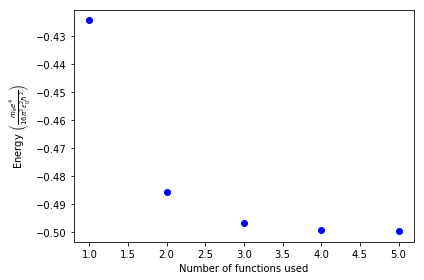

In [13]:
# plot energy convergence
plt.figure(1)
plt.plot(e_x, e_y, 'ob')
plt.xlabel('Number of functions used')
plt.ylabel(r'Energy $\left(\frac{m_ee^4}{16\pi^2\epsilon_0^2\hbar^2}\right)$')
plt.tight_layout()
plt.show()

Finally, plot the best (lowest ground state energy) approximate function $\phi$ alongside the guassians that compose $\phi$ and the exact solution.

Normalization Factor: 0.2611183268330305


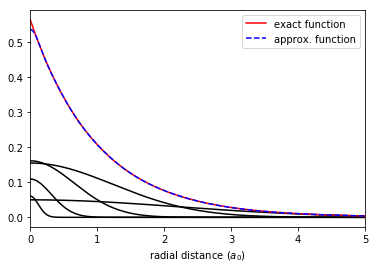

In [14]:
all_e_vals = [i[3] for i in solutions]
indx = int(np.argmin(all_e_vals))

final_solution = (solutions[indx][2], solutions[indx][4])
final_solution = list(zip(*final_solution))


def exact_h(r):
    return math.sqrt(1 / math.pi) * math.exp(-r)


def sol(final_sol):
    def lc_function(r):
        s = 0
        for i in final_sol:
            # print('c: {} alpha: {}'.format(i[1], i[0]))
            s += i[1] * math.exp(-i[0] * r ** 2)
        return s
    return lc_function


def partial_sol(c, alpha):
    def func(r):
            return c * math.exp(-alpha * r ** 2)
    return func


# get normalization factor
def get_norm_factor(func):
    def integrand(r):
        return 4 * math.pi * r ** 2 * func(r) ** 2

    def wf_eval_int(lower, upper, function_int):
        dx = (upper-lower)/1000
        return np.trapz([function_int(x) for x in np.arange(lower, upper, dx)], dx=dx)

    I = wf_eval_int(0, 10, integrand)
    return math.sqrt(1/I)


lc_sol = sol(final_solution)
norm_factor = get_norm_factor(lc_sol)
print('Normalization Factor: {}'.format(norm_factor))

ind_funcs = [partial_sol(i[1], i[0]) for i in final_solution]

x = np.linspace(0, 5, 1000)
plt.figure(2)
for c, i in enumerate(ind_funcs, 1):
    y = [math.fabs(i(j)) * norm_factor for j in x]
    str_label = '$\phi_{}$'.format(c)
    plt.plot(x, y, '-k')

y = [exact_h(j) for j in x]
plt.plot(x, y, '-r', label='exact function')

y = [math.fabs(lc_sol(j)) * norm_factor for j in x]
plt.plot(x, y, '--b', label='approx. function')

plt.xlim(0, 5)
plt.legend()
plt.xlabel('radial distance $(a_0)$')
plt.show()